# Final Project
**GitHub:** [github.com/ketantotlaniusc](https://github.com/ketantotlaniusc)  
**USCID:** 7386-0850-62

In [ ]:
# import libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Transfer Learning for Image Classification

### (a) In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

### (b) Data Exploration and Pre-processing

In [ ]:
IMG_DIR = '../data/RealWaste'
classes = sorted(os.listdir(IMG_DIR))

# Data Splitting - Take first 80% of sorted images in each folder
data = []
for label in classes:
    folder_path = os.path.join(IMG_DIR, label)
    image_paths = sorted(glob.glob(folder_path + "/*.jpg"))

    # Split based on first 80% of images
    n_train = int(len(image_paths) * 0.8)
    train_images = image_paths[:n_train]
    test_images = image_paths[n_train:]

    # Create train dataframe
    for img in train_images:
        data.append((img, label, 'train'))

    # Create test dataframe
    for img in test_images:
        data.append((img, label, 'test'))

df = pd.DataFrame(data, columns=['filename', 'label', 'split'])

# Split training into train and validation (20% of training)
df_train = df[df['split'] == 'train'].copy()
df_test = df[df['split'] == 'test'].copy()

# Randomly select 20% from each class in training for validation
df_val = pd.DataFrame()
for label in classes:
    label_df = df_train[df_train['label'] == label]
    val_df = label_df.sample(frac=0.2, random_state=42)
    df_val = pd.concat([df_val, val_df])

# Remove validation samples from training
df_train = df_train.drop(df_val.index)

print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

Train: 3038 | Val: 760 | Test: 954


In [ ]:
# Preprocessing function for contrast adjustment
def adjust_contrast(img):
    return tf.image.adjust_contrast(img, contrast_factor=np.random.uniform(0.9, 1.1))  # subtle contrast

IMG_SIZE = 224
BATCH_SIZE = 64

train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=adjust_contrast,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_data = test_gen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_data = test_gen.flow_from_dataframe(
    df_test,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3038 validated image filenames belonging to 9 classes.
Found 760 validated image filenames belonging to 9 classes.
Found 954 validated image filenames belonging to 9 classes.


### (c) Transfer Learning

In [ ]:
def build_model(base_model_fn):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    output = Dense(len(train_data.class_indices), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### Evaluation and Plotting Functions

In [ ]:
def evaluate_model(model, data, name):
    y_true = []
    y_pred_probs = []

    for x_batch, y_batch in data:
        preds = model.predict(x_batch)
        y_pred_probs.extend(preds)
        y_true.extend(np.argmax(y_batch, axis=1))
        if len(y_true) >= data.n:  # ensure we stop after all images
            break

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Print classification report
    print(f"\n{name} Classification Report:\n",
          classification_report(y_true, y_pred, target_names=list(data.class_indices.keys()), zero_division=0))

    # Compute accuracy
    acc = accuracy_score(y_true, y_pred)

    # Extract precision, recall, F1 from report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    macro_f1 = report['macro avg']['f1-score']
    weighted_f1 = report['weighted avg']['f1-score']
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']

    # Compute AUC
    try:
        y_true_bin = tf.keras.utils.to_categorical(y_true)
        auc = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr')
        print(f"{name} AUC Score: {auc:.4f}")
    except:
        auc = None
        print(f"{name} AUC Score: Not computable.")

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "auc": auc
    }


def plot_history(history, name):
    train_error = [1 - acc for acc in history.history['accuracy']]
    val_error = [1 - acc for acc in history.history['val_accuracy']]

    plt.figure(figsize=(18, 5))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Error
    plt.subplot(1, 3, 3)
    plt.plot(train_error, label='Train Error')
    plt.plot(val_error, label='Validation Error')
    plt.title(f'{name} Error (1 - Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(model, data, true_labels, model_name):
    predictions = model.predict(data)
    predicted_classes = np.argmax(predictions, axis=1)
    cm = confusion_matrix(true_labels, predicted_classes)

    fig, ax = plt.subplots(figsize=(10, 8))  # Make it taller to prevent overlap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()  # Helps auto-adjust layout
    plt.show()

# Dictionary to store results for comparison
results = {}

In [ ]:
# ResNet50 Training
print("Training model: ResNet50")
model_resnet50 = build_model(ResNet50)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=50)
history_resnet50 = model_resnet50.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stop]
)

Training model: ResNet50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5024 - loss: 3.8754 - val_accuracy: 0.6618 - val_loss: 3.1040
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7640 - loss: 2.6635 - val_accuracy: 0.7316 - val_loss: 2.4382
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8481 - loss: 2.0469 - val_accuracy: 0.7513 - val_loss: 2.0005
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8554 - loss: 1.6745 - val_accuracy: 0.7882 - val_loss: 1.6784
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8764 - loss: 1.3747 - val_accuracy: 0.7632 - val_loss: 1.5317
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8951 - loss: 1.1409 - val_accuracy: 0.7829 - val_loss: 1.2817
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8779 - loss: 1.0157 - val_accuracy: 0.7842 - val_loss: 1.1946
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9037 - loss: 0.8714 - val_accuracy: 0.7974 - v

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 579ms/step


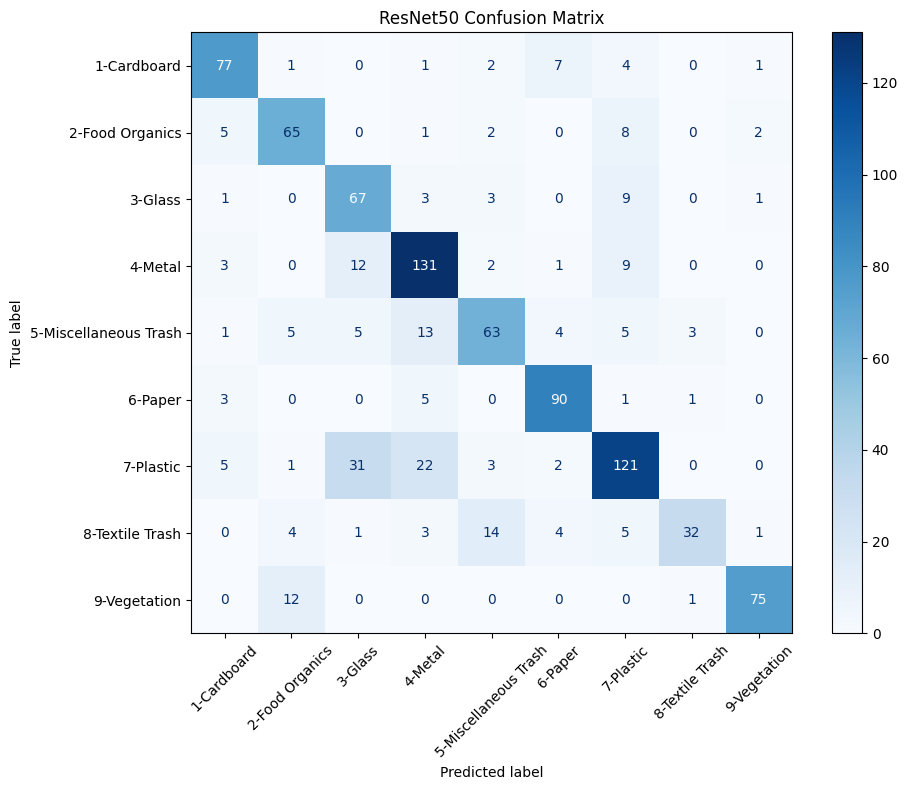

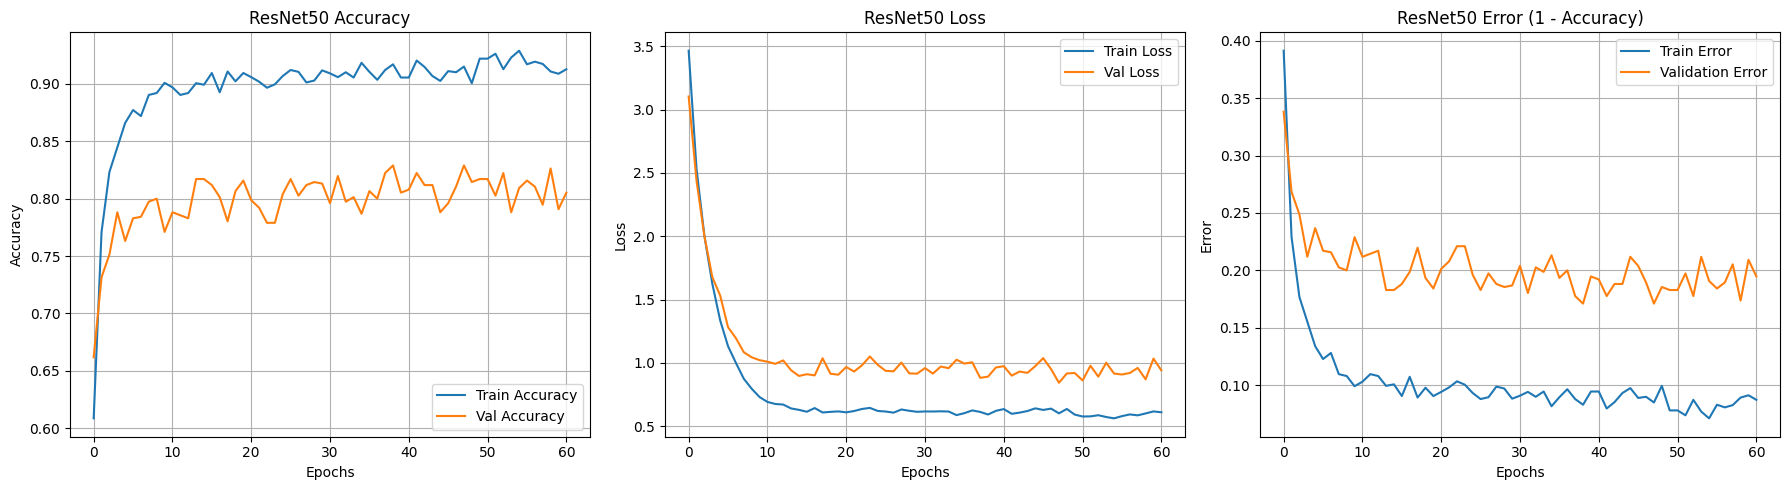


Evaluating ResNet50 model:
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━

In [ ]:
true_test_labels = test_data.classes

# ResNet50 Confusion Matrix
plot_confusion_matrix(model_resnet50, test_data, true_test_labels, "ResNet50")

# ResNet50 Evaluation
plot_history(history_resnet50, "ResNet50")

# Evaluate model and store metrics
print("\nEvaluating ResNet50 model:")
train_metrics_resnet50 = evaluate_model(model_resnet50, train_data, "ResNet50 - Train")
val_metrics_resnet50 = evaluate_model(model_resnet50, val_data, "ResNet50 - Validation")
test_metrics_resnet50 = evaluate_model(model_resnet50, test_data, "ResNet50 - Test")

# Store metrics for later comparison
results['ResNet50'] = {
    'train': train_metrics_resnet50,
    'val': val_metrics_resnet50,
    'test': test_metrics_resnet50,
}

# Prepare summary DataFrame for clean display
summary_df = pd.DataFrame([
    {'Dataset': 'Train', **train_metrics_resnet50},
    {'Dataset': 'Validation', **val_metrics_resnet50},
    {'Dataset': 'Test', **test_metrics_resnet50},
])

# Pretty print
print("\n--- ResNet50 Performance Summary ---")
print(summary_df.round(4))  # rounding to 4 decimal places for neatness

In [ ]:
# ResNet101 Training
print("Training model: ResNet101")
model_resnet101 = build_model(ResNet101)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=50)
history_resnet101 = model_resnet101.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stop]
)

Training model: ResNet101
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4764 - loss: 4.0293 - val_accuracy: 0.6803 - val_loss: 2.9628
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7837 - loss: 2.5907 - val_accuracy: 0.7526 - val_loss: 2.3645
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8228 - loss: 2.0756 - val_accuracy: 0.7263 - val_loss: 2.0694
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8527 - loss: 1.6725 - val_accuracy: 0.7934 - val_loss: 1.6330
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8660 - loss: 1.3715 - val_accuracy: 0.7763 - val_loss: 1.4692
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8799 - loss: 1.1623 - val_accuracy: 0.7868 - val_loss: 1.2825
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8865 - loss: 0.9895 - val_accuracy: 0.7605 - val_loss: 1.2387
Epoch 8/100
48/48 ━━━━━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 824ms/step


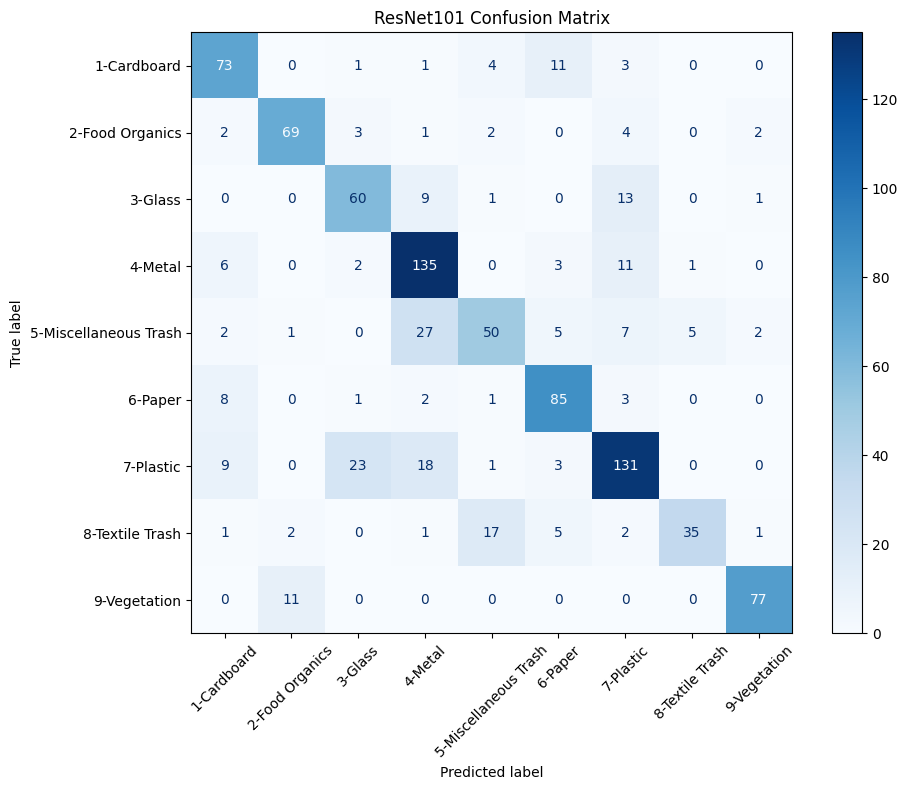

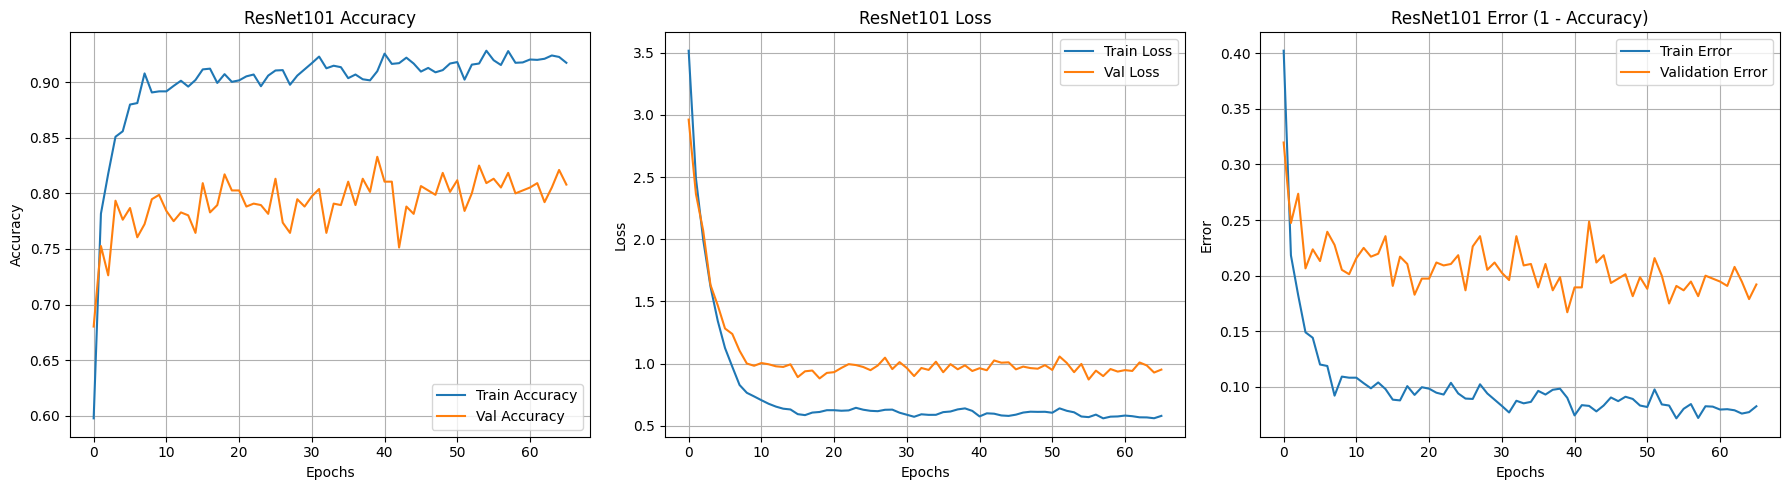


Evaluating ResNet101 model:
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━

In [ ]:
true_test_labels = test_data.classes
# ResNet101 Confusion Matrix
plot_confusion_matrix(model_resnet101, test_data, true_test_labels, "ResNet101")

# ResNet101 Evaluation
plot_history(history_resnet101, "ResNet101")

# Evaluate model and store metrics
print("\nEvaluating ResNet101 model:")
train_metrics_resnet101 = evaluate_model(model_resnet101, train_data, "ResNet101 - Train")
val_metrics_resnet101 = evaluate_model(model_resnet101, val_data, "ResNet101 - Validation")
test_metrics_resnet101 = evaluate_model(model_resnet101, test_data, "ResNet101 - Test")

# Store metrics in dictionary for later comparison
results['ResNet101'] = {
    'train': train_metrics_resnet101,
    'val': val_metrics_resnet101,
    'test': test_metrics_resnet101,
}

# Display a neat summary DataFrame
summary_df = pd.DataFrame([
    {'Dataset': 'Train', **train_metrics_resnet101},
    {'Dataset': 'Validation', **val_metrics_resnet101},
    {'Dataset': 'Test', **test_metrics_resnet101},
])

print("\n--- ResNet101 Performance Summary ---")
print(summary_df.round(4))  # Rounded for cleaner output

In [ ]:
# VGG16 Training
print("Training model: VGG16")
model_vgg16 = build_model(VGG16)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=50)
history_vgg16 = model_vgg16.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stop]
)

Training model: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.2838 - loss: 4.1547 - val_accuracy: 0.5803 - val_loss: 3.0713
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6423 - loss: 2.7101 - val_accuracy: 0.6566 - val_loss: 2.4883
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7129 - loss: 2.2398 - val_accuracy: 0.6711 - val_loss: 2.1016
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7487 - loss: 1.9030 - val_accuracy: 0.7053 - val_loss: 1.8200
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7604 - loss: 1.6253 - val_accuracy: 0.6934 - val_loss: 1.6502
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7857 - loss: 1.4173 - val_accuracy: 0.7000 - val_loss: 1.5008
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7868 - loss: 1.2941 - val_accuracy: 0.7316 - val_loss: 1.3177
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 573ms/step


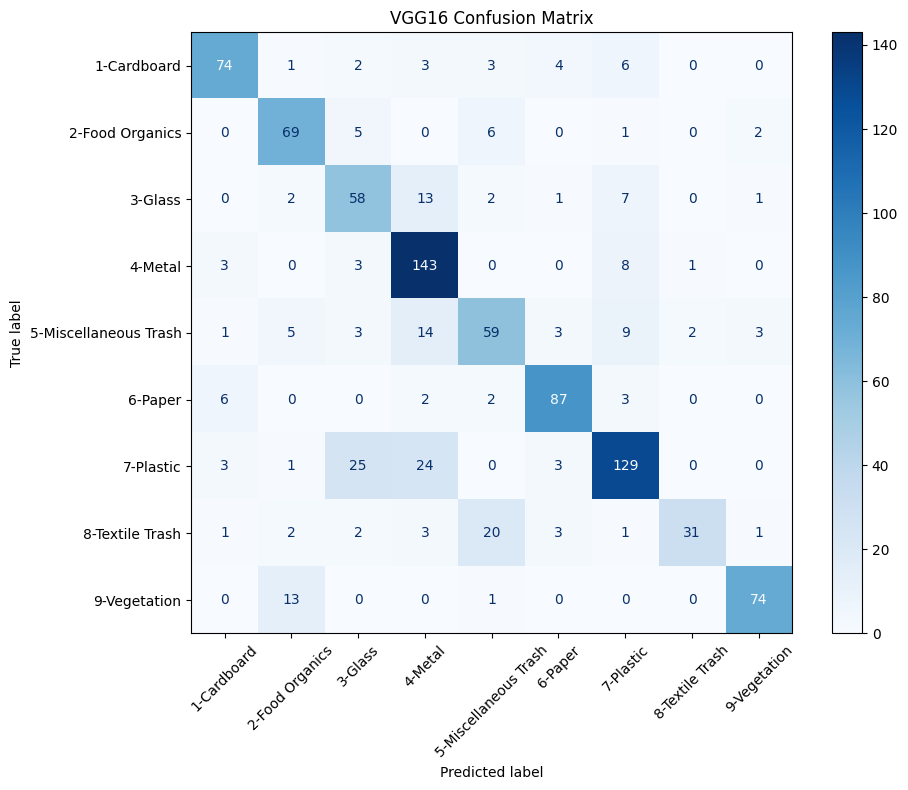

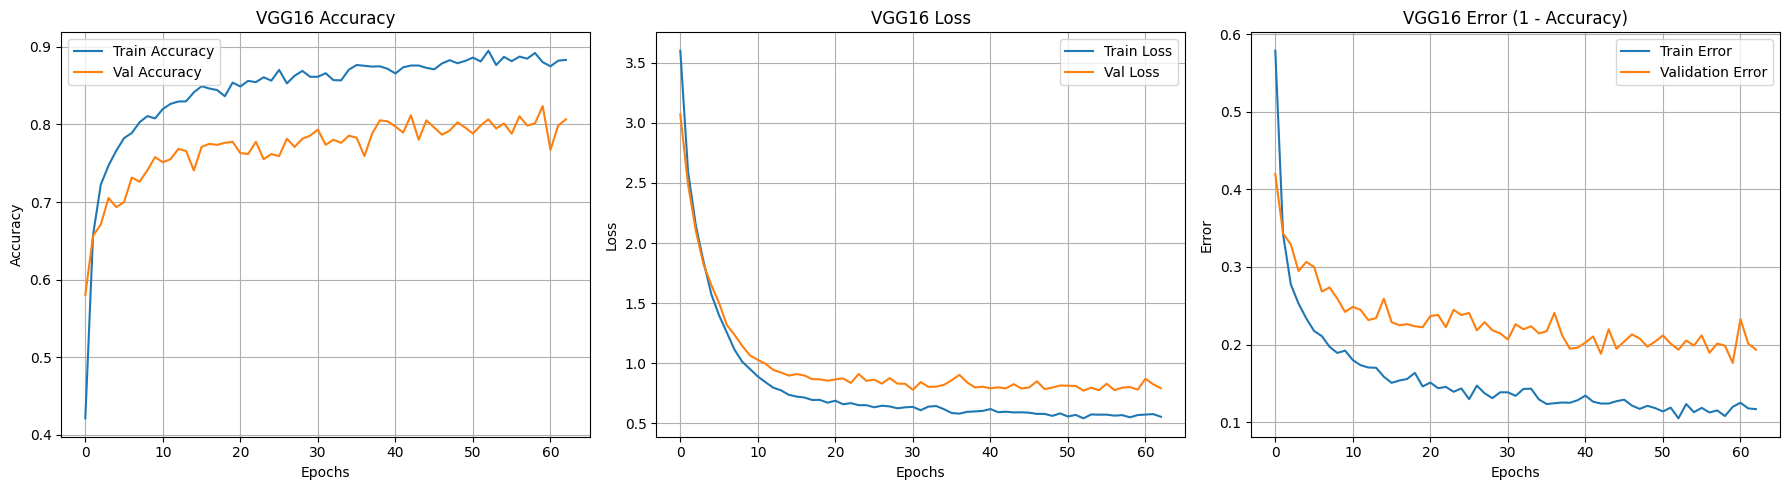


Evaluating VGG16 model:
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
true_test_labels = test_data.classes
# VGG16 Confusion Matrix
plot_confusion_matrix(model_vgg16, test_data, true_test_labels, "VGG16")

# VGG16 Evaluation
plot_history(history_vgg16, "VGG16")

# Evaluate model and store metrics
print("\nEvaluating VGG16 model:")
train_metrics_vgg16 = evaluate_model(model_vgg16, train_data, "VGG16 - Train")
val_metrics_vgg16 = evaluate_model(model_vgg16, val_data, "VGG16 - Validation")
test_metrics_vgg16 = evaluate_model(model_vgg16, test_data, "VGG16 - Test")

# Store metrics for comparison
results['VGG16'] = {
    'train': train_metrics_vgg16,
    'val': val_metrics_vgg16,
    'test': test_metrics_vgg16,
}

# Display summary of VGG16 results
summary_df = pd.DataFrame([
    {'Dataset': 'Train', **train_metrics_vgg16},
    {'Dataset': 'Validation', **val_metrics_vgg16},
    {'Dataset': 'Test', **test_metrics_vgg16},
])

print("\n--- VGG16 Performance Summary ---")
print(summary_df.round(4))

In [ ]:
# EfficientNetB0 Training
print("Training model: EfficientNetB0")
model_efficientnet = build_model(EfficientNetB0)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=50)
history_efficientnet = model_efficientnet.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stop]
)

Training model: EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4605 - loss: 3.8702 - val_accuracy: 0.6855 - val_loss: 2.9981
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7991 - loss: 2.4533 - val_accuracy: 0.7342 - val_loss: 2.4373
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8427 - loss: 1.9340 - val_accuracy: 0.7539 - val_loss: 2.0001
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8544 - loss: 1.5825 - val_accuracy: 0.7763 - val_loss: 1.6133
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8953 - loss: 1.2584 - val_accuracy: 0.7776 - val_loss: 1.3729
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8910 - loss: 1.0655 - val_accuracy: 0.7803 - val_loss: 1.2324
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8982 - loss: 0.8922 - val_accuracy: 0.8066 - val_loss: 1.0301
Epoch 8/100
48/48 ━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


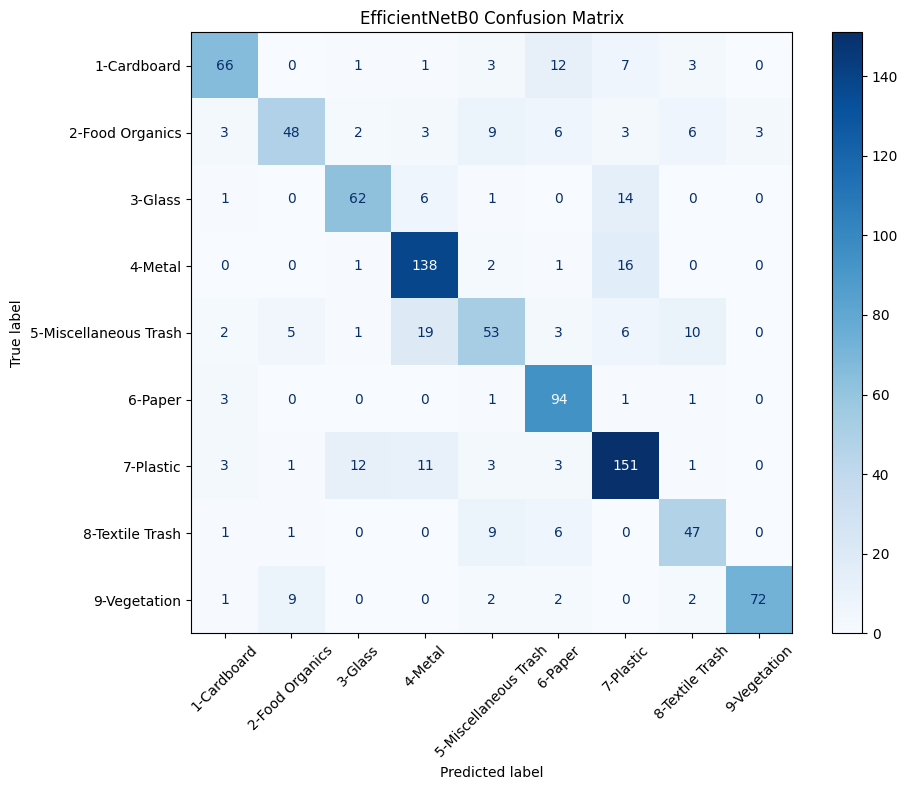

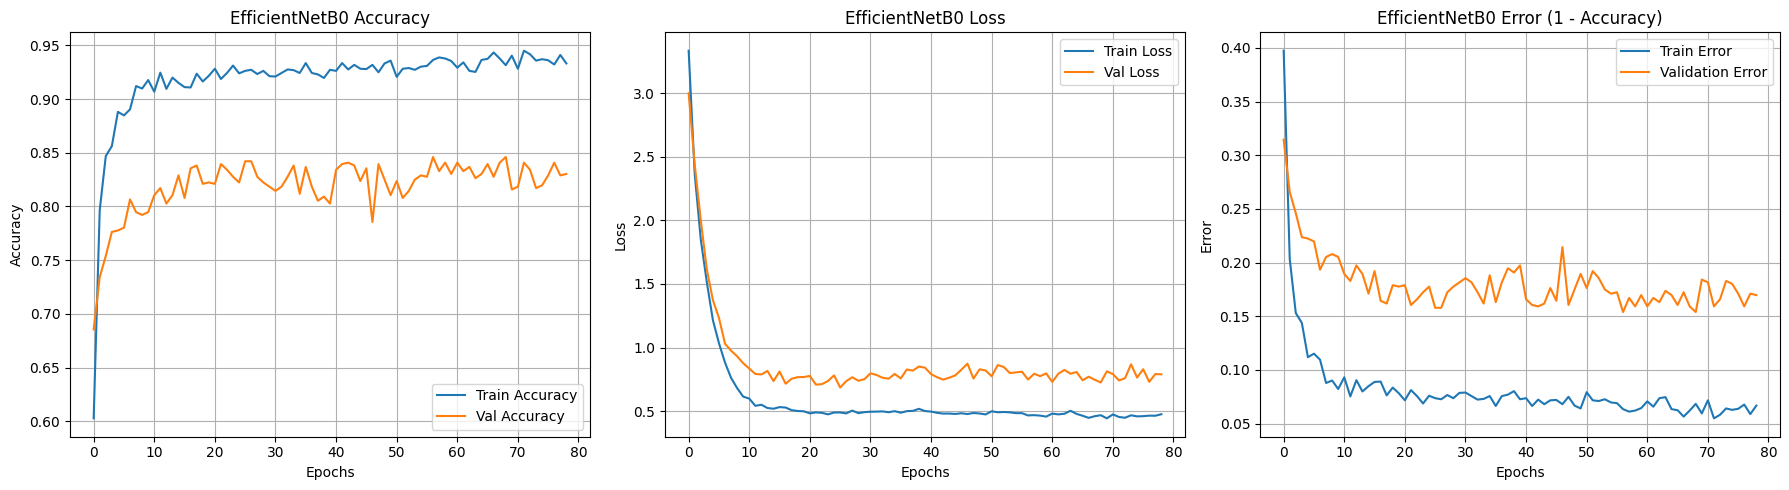


Evaluating EfficientNetB0 model:
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━

In [ ]:
true_test_labels = test_data.classes
# EfficientNetB0 Confusion Matrix
plot_confusion_matrix(model_efficientnet, test_data, true_test_labels, "EfficientNetB0")

# EfficientNetB0 Evaluation
plot_history(history_efficientnet, "EfficientNetB0")

# Evaluate model and store metrics
print("\nEvaluating EfficientNetB0 model:")
train_metrics_efficientnet = evaluate_model(model_efficientnet, train_data, "EfficientNetB0 - Train")
val_metrics_efficientnet = evaluate_model(model_efficientnet, val_data, "EfficientNetB0 - Validation")
test_metrics_efficientnet = evaluate_model(model_efficientnet, test_data, "EfficientNetB0 - Test")

# Store metrics for comparison
results['EfficientNetB0'] = {
    'train': train_metrics_efficientnet,
    'val': val_metrics_efficientnet,
    'test': test_metrics_efficientnet,
}

# Display summary of EfficientNetB0 results
summary_df = pd.DataFrame([
    {'Dataset': 'Train', **train_metrics_efficientnet},
    {'Dataset': 'Validation', **val_metrics_efficientnet},
    {'Dataset': 'Test', **test_metrics_efficientnet},
])

print("\n--- EfficientNetB0 Performance Summary ---")
print(summary_df.round(4))

## Final Conclusion


--- Model Performance Comparison (AUC Only) ---
            Model  Train AUC  Validation AUC  Test AUC
0        ResNet50     0.9982          0.9841    0.9631
1       ResNet101     0.9989          0.9824    0.9684
2           VGG16     0.9982          0.9804    0.9670
3  EfficientNetB0     0.9995          0.9876    0.9730


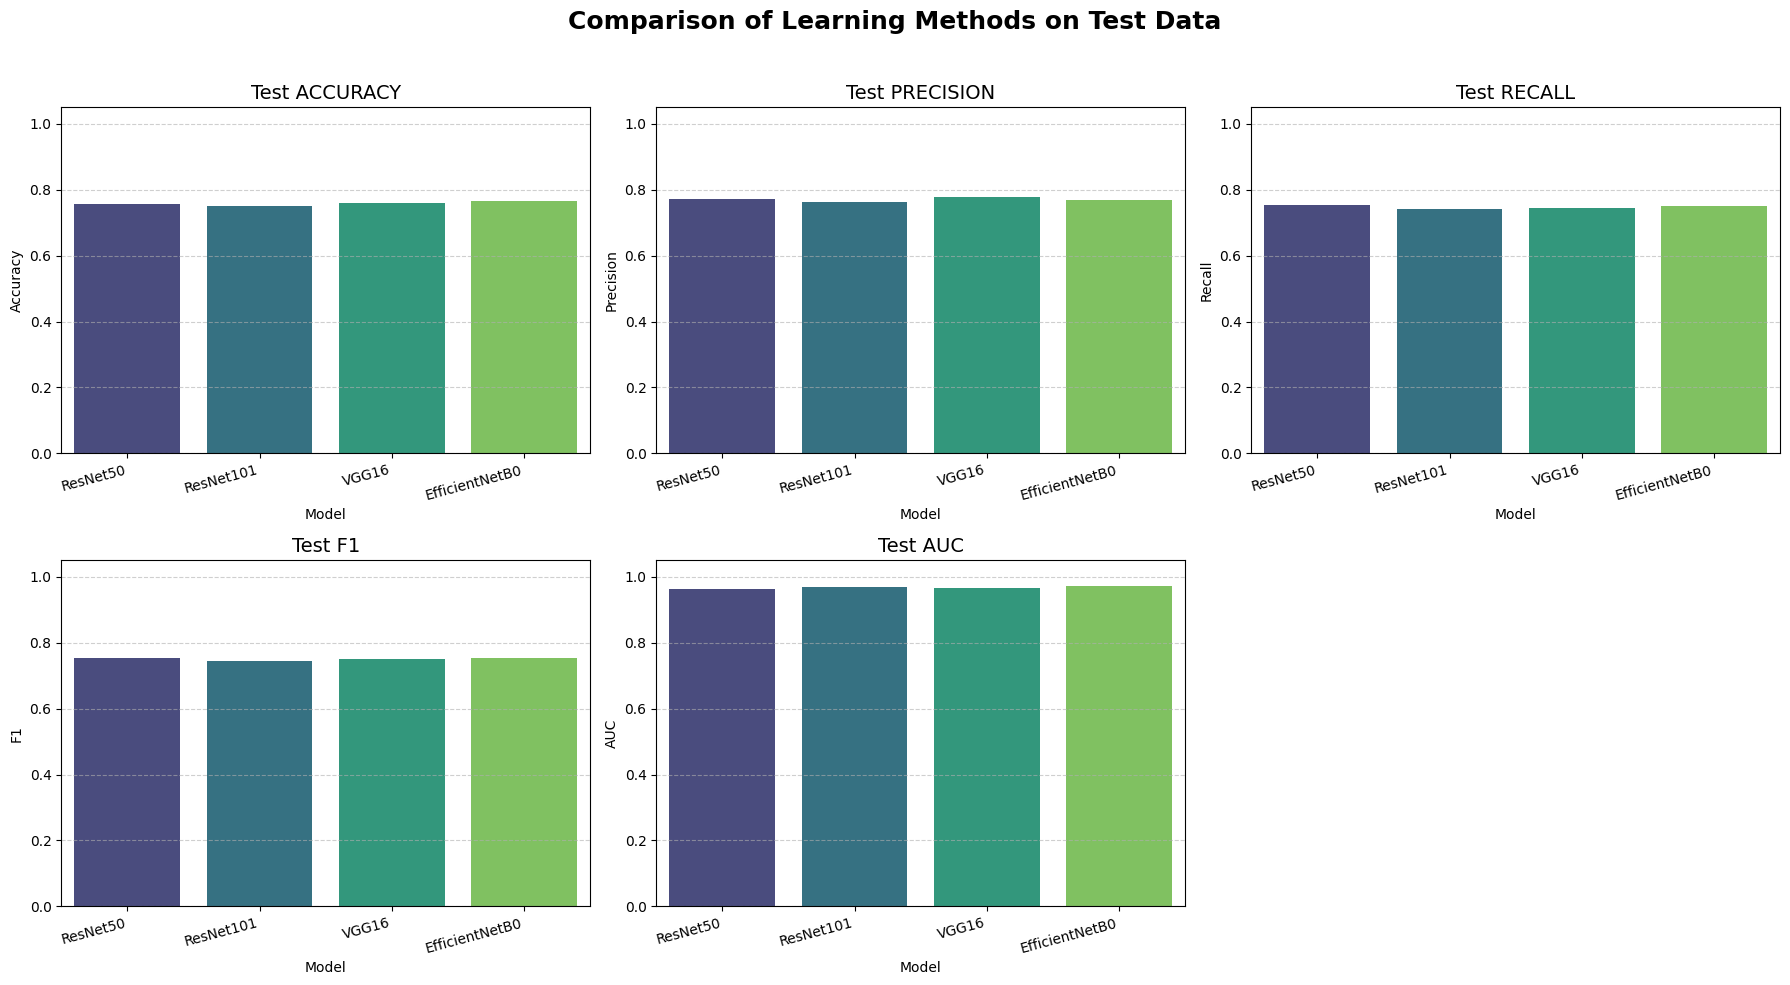

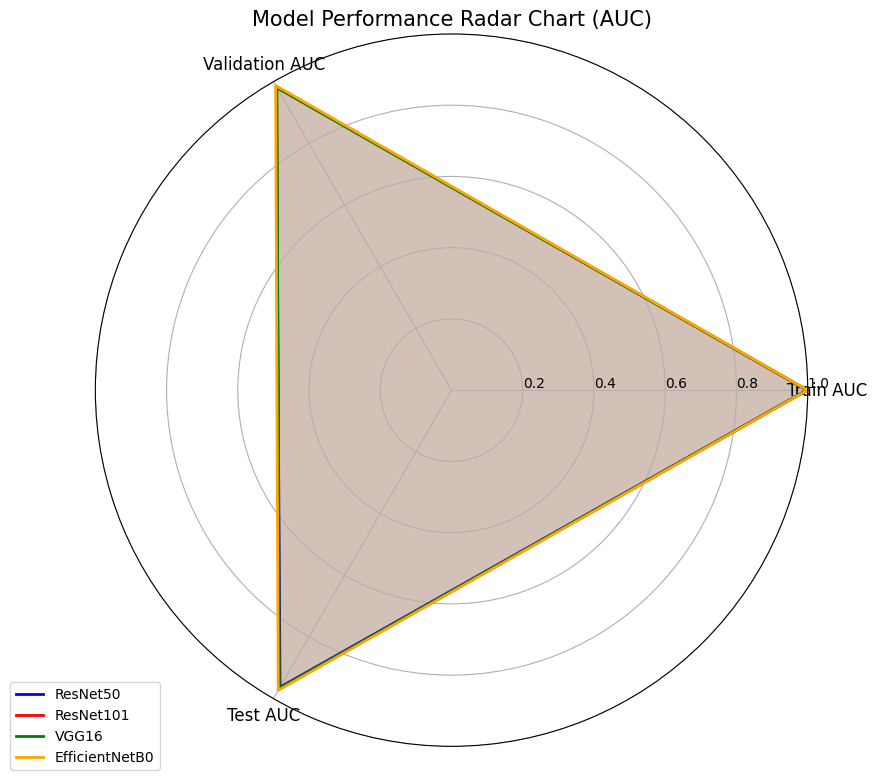


--- Test Set Metrics for All Models ---

📊 ResNet50 Test Performance:
Accuracy       : 0.7558
Macro F1 Score : 0.7540
Weighted F1    : 0.7541
Precision      : 0.7721
Recall         : 0.7534
AUC Score      : 0.9631

📊 ResNet101 Test Performance:
Accuracy       : 0.7495
Macro F1 Score : 0.7457
Weighted F1    : 0.7461
Precision      : 0.7631
Recall         : 0.7411
AUC Score      : 0.9684

📊 VGG16 Test Performance:
Accuracy       : 0.7589
Macro F1 Score : 0.7513
Weighted F1    : 0.7567
Precision      : 0.7767
Recall         : 0.7457
AUC Score      : 0.9670

📊 EfficientNetB0 Test Performance:
Accuracy       : 0.7673
Macro F1 Score : 0.7547
Weighted F1    : 0.7640
Precision      : 0.7686
Recall         : 0.7505
AUC Score      : 0.9730

--- Final Conclusion ---
After evaluating all models, we find that EfficientNetB0 outperforms the others in terms of AUC score.
It achieved a test AUC of 0.9730, making it the best candidate for this task.


In [32]:
# Step 1: Create comparison DataFrame for AUC
comparison_data = []
metric_data = []  # For bar chart with all metrics

for model_name, result in results.items():
    row = {
        'Model': model_name,
        'Train AUC': result['train']['auc'],
        'Validation AUC': result['val']['auc'],
        'Test AUC': result['test']['auc']
    }
    comparison_data.append(row)

    metric_row = {
        'Model': model_name,
        'Accuracy': result['test']['accuracy'],
        'Precision': result['test']['macro_precision'],
        'Recall': result['test']['macro_recall'],
        'F1': result['test']['macro_f1'],
        'AUC': result['test']['auc']
    }
    metric_data.append(metric_row)

comparison_df = pd.DataFrame(comparison_data)
metrics_df = pd.DataFrame(metric_data)

print("\n--- Model Performance Comparison (AUC Only) ---")
print(comparison_df.round(4))

# Step 2: Multi-metric bar plots like the image
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(ax=axs[i], data=metrics_df, x='Model', y=metric, hue='Model', legend=False, palette='viridis')
    axs[i].set_title(f'Test {metric.upper()}', fontsize=14)
    axs[i].set_ylim(0, 1.05)
    axs[i].set_xticks(np.arange(len(metrics_df['Model'])))  # FIX
    axs[i].set_xticklabels(metrics_df['Model'], rotation=15, ha='right')
    axs[i].grid(axis='y', linestyle='--', alpha=0.6)

# Hide unused subplot (6th)
axs[-1].axis('off')

plt.suptitle('Comparison of Learning Methods on Test Data', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Step 3: Radar chart for AUC
plt.figure(figsize=(10, 8))
categories = ['Train AUC', 'Validation AUC', 'Test AUC']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, size=12)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
plt.ylim(0, 1)

colors = ['blue', 'red', 'green', 'orange']
for i, (_, row) in enumerate(comparison_df.iterrows()):
    model_name = row['Model']
    values = [row['Train AUC'], row['Validation AUC'], row['Test AUC']]
    values = [0 if v is None else v for v in values]
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', color=colors[i], label=model_name)
    ax.fill(angles, values, alpha=0.1, color=colors[i])

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Performance Radar Chart (AUC)', size=15)
plt.tight_layout()
plt.show()

# Step 4: Show test metrics for all models
print("\n--- Test Set Metrics for All Models ---")
for model_name, model_results in results.items():
    test = model_results['test']
    print(f"\n📊 {model_name} Test Performance:")
    print(f"Accuracy       : {test['accuracy']:.4f}")
    print(f"Macro F1 Score : {test['macro_f1']:.4f}")
    print(f"Weighted F1    : {test['weighted_f1']:.4f}")
    print(f"Precision      : {test['macro_precision']:.4f}")
    print(f"Recall         : {test['macro_recall']:.4f}")
    print(f"AUC Score      : {test['auc']:.4f}" if test['auc'] is not None else "AUC Score      : Not computable")

# Step 5: Final AUC-based conclusion
valid_models = comparison_df.dropna(subset=['Test AUC'])
if not valid_models.empty:
    best_idx = valid_models['Test AUC'].idxmax()
    best_model = valid_models.loc[best_idx, 'Model']
    best_test_auc = valid_models.loc[best_idx, 'Test AUC']
    best_metrics = results[best_model]['test']

    print("\n--- Final Conclusion ---")
    print(f"After evaluating all models, we find that {best_model} outperforms the others in terms of AUC score.")
    print(f"It achieved a test AUC of {best_test_auc:.4f}, making it the best candidate for this task.")
else:
    print("\nCould not determine the best model due to missing test AUC values.")


After conducting extensive experimentation with four pre-trained convolutional neural networks — ResNet50, ResNet101, VGG16, and EfficientNetB0 — we found that all models performed comparably well on the multi-class waste classification task. While EfficientNetB0 slightly outperformed the others in terms of test accuracy and AUC, the margins were modest, with VGG16 and ResNet50 closely trailing behind.

Overall, EfficientNetB0 demonstrated the best generalization performance on unseen data, making it a suitable candidate for real-world applications. However, depending on specific deployment constraints (e.g., model size or inference speed), ResNet50 or VGG16 could also be viable alternatives without significant drops in performance.